# Well Count Analysis Notebook: 2 polygons through geopandas

The purpose of this code is to give percentages of wells classified as having shallow groundwater and their relative proximity to streams.

To run this code, you need the following files in the appropriate folders:
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated.csv
 - Data/Input/Shapefiles
   - flowlines_order#plus.shp
   - WBDHU#.shp

In [ ]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys
import seaborn as sns
import math
import gc
import time

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Fun functions unique to this script
# Classify DTW values into categories 
def classify_dtw(dtw):
    if dtw < 2:
        return 'Near Surface (<2m)'
    elif 2 <= dtw < 5:
        return 'Very Shallow (2-5m)'
    elif 5 <= dtw < 10:
        return 'Shallow (5-10m)'
    else:
        return 'Deep (10-61m)'
    
def log_time(start, message):
    print(f"{message}. Elapsed time: {time.time() - start:.2f}s")

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local/'




Providing colors

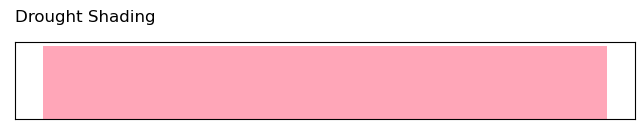

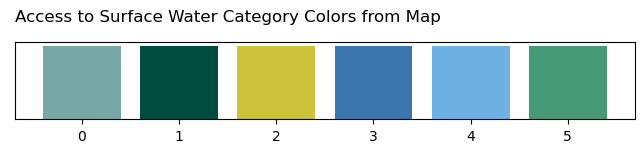

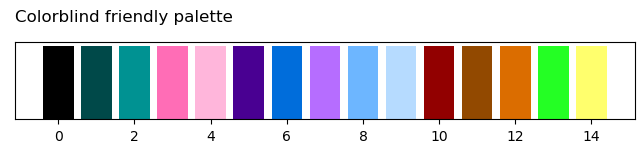

In [ ]:
# %% Creating colors
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Colors from map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map in the trend paper
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'
a2sw_colors =[cap,cap_secondary,noCAP,GWdom,mixed,swdom]

# Create a bar plot to visualize colors
palette = [drought_color]
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Drought Shading',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
ax.set_xticks([])
plt.show()

palette = a2sw_colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Access to Surface Water Category Colors from Map',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()

Read in the main databases.  You only have to do this once.

Master Database might take a while unless you use dask (~5-7 minutes).

In [ ]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'dask_geopandas.core.GeoDataFrame'>
Columns: 80 entries, Combo_ID to geometry
dtypes: geometry(1), object(59), float64(20)None


Here too, using dask went from taking 3 minutes to one minute (mostly for formatting)

In [ ]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

# filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated.csv'
filename_ts = 'Wells55_GWSI_WLTS_DB_monthly.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)
annual_db = annual_db.set_index('date')

# #Block to do some formatting
annual_db = annual_db[1:168102] # Use this if you read in with pandas
annual_db2 = annual_db.reset_index(inplace=True)
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db2.rename(columns = {'date':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_monthly.csv


,Combo_ID,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,...,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,483.90,NaN,NaN,NaN
1,83578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### From here down is where you can rerun the code to generate graphs

In [ ]:
# Put your huc number here
huc_num = '4'

In [ ]:
# Read in the reach shapefile

# filename_shapeile = '/flowlines_order4plus.shp'
filename_shapeile = '/huc'+huc_num+'flowlines_order3plus.shp'
filepath = os.path.join(shapepath, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')

Take a look at the columns and variables

In [ ]:
shapefile

,permanent_,gnis_name,reachcode,streamorde,ID,huc4,huc_name,fcode,hydroseq,geometry
npartitions=10,,,,,,,,,,
0,object,object,object,int32,object,object,object,int32,float64,geometry
35572,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
320148,...,...,...,...,...,...,...,...,...,...
355713,...,...,...,...,...,...,...,...,...,...


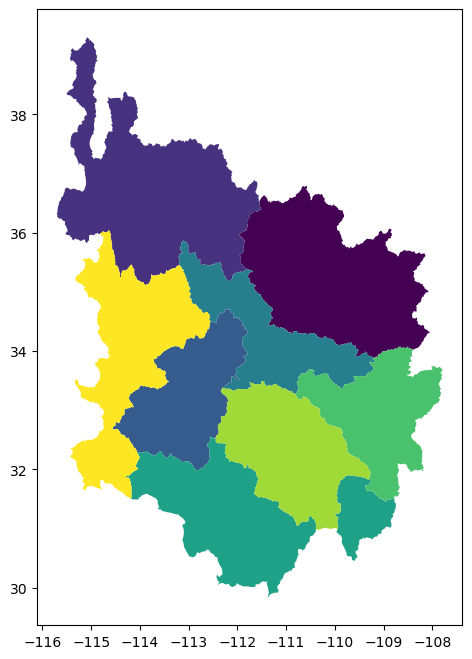

In [ ]:
# Read in the watershed boundary shapefile
filename_shapeile = 'WBDHU'+huc_num+'.shp'
filepath = os.path.join(shapepath+"/WBD_15_HU2_Shape/Shape/", filename_shapeile) #This is the path for my laptop

# For using geopandas:
filepath = os.path.join(shapepath+"/NHD_H_Arizona_State_Shape/Shape/",filename_shapeile)
shapefile_wbd = gp.read_file(filepath)
shapefile_wbd.plot(cmap='viridis')


Take a look at the columns and variables

In [ ]:
shapefile_wbd = shapefile_wbd[['huc'+huc_num+'_wb','geometry']]
shapefile_wbd

,huc4_wb,geometry
npartitions=8,,
0,object,geometry
1,...,...
...,...,...
7,...,...
7,...,...


In [ ]:
# Define some things about your file

StudyArea = "HUC"+huc_num+"s"
Naming_col = "huc"+huc_num+""


Merging the databases takes a little time - Approximately 3 minutes

In [ ]:
# Merge the shapefile with the master database

# For geopandas
shapefile_wbd = shapefile_wbd.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
static_geo = gp.sjoin(masterdb2, shapefile_wbd, how="inner"
                    #   , op='intersects'
                      , predicate='intersects'
                      )

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


Master_ADWR_database_noduplicates.shp and WBDHU4.shp join complete.


Check to make sure the merged dataframe looks good

In [ ]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,WELL_ALT,WATER_USE_,WELL_DEPTH,CASE_DIAM,WL_COUNT,WL_DTW,WL_ELEV,SOURCE,IDXBK,DRILL_DATE,LASTWLDATE,QUASI_IDX_,GOES_ENABL,TRANSDUCER,IDXBK2,FREQUENCY,Original_D,OBJECTID_w,PROGRAM,OWNER_NAME,RGR_PUMP_D,WELLTYPE,WELL_TYPE_,DLIC_NUM,APPROVED,INSTALLED,WATER_LEVE,CASING_DEP,CASING_DIA,CASING_TYP,PUMP_TYPE,PUMP_POWER,PUMPRATE,TESTEDRATE,DRAW_DOWN,COMPLETION,DRILL_LOG,WELL_CANCE,CADASTRAL,COUNTY,WATERSHED,BASIN_NAME,SUBBASIN_N,AMA,QUAD_CODE,WHOLE_TOWN,HALF_TOWNS,NORTHSOUTH,WHOLE_RANG,HALF_RANGE,EASTWEST,SECTION,QUARTER_16,QACRE160DI,QUARTER_40,QACRE40DIR,QUARTER_10,QACRE10DIR,UTM_X_METE,UTM_Y_METE,APPLICATIO,ADDRESS1,ADDRESS2,CITY,STATE,ZIP,ZIP4,WATER_US_1,SITE_USE,geometry,index_right,huc4_wb
npartitions=80,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,object,object,object,object,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,object,float64,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,object,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,geometry,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
static_geo = static_geo.drop(columns='index_right')
static_geo.columns

Index(['Combo_ID', 'OBJECTID_g', 'SITE_ID', 'LOCAL_ID', 'REGISTRY_I',
       'WELL_TYPE', 'DD_LAT', 'DD_LONG', 'LAT_NAD27', 'LONG_NAD27', 'WELL_ALT',
       'WATER_USE_', 'WELL_DEPTH', 'CASE_DIAM', 'WL_COUNT', 'WL_DTW',
       'WL_ELEV', 'SOURCE', 'IDXBK', 'DRILL_DATE', 'LASTWLDATE', 'QUASI_IDX_',
       'GOES_ENABL', 'TRANSDUCER', 'IDXBK2', 'FREQUENCY', 'Original_D',
       'OBJECTID_w', 'PROGRAM', 'OWNER_NAME', 'RGR_PUMP_D', 'WELLTYPE',
       'WELL_TYPE_', 'DLIC_NUM', 'APPROVED', 'INSTALLED', 'WATER_LEVE',
       'CASING_DEP', 'CASING_DIA', 'CASING_TYP', 'PUMP_TYPE', 'PUMP_POWER',
       'PUMPRATE', 'TESTEDRATE', 'DRAW_DOWN', 'COMPLETION', 'DRILL_LOG',
       'WELL_CANCE', 'CADASTRAL', 'COUNTY', 'WATERSHED', 'BASIN_NAME',
       'SUBBASIN_N', 'AMA', 'QUAD_CODE', 'WHOLE_TOWN', 'HALF_TOWNS',
       'NORTHSOUTH', 'WHOLE_RANG', 'HALF_RANGE', 'EASTWEST', 'SECTION',
       'QUARTER_16', 'QACRE160DI', 'QUARTER_40', 'QACRE40DIR', 'QUARTER_10',
       'QACRE10DIR', 'UTM_X_METE', 'UTM_Y_METE'

In [ ]:
# Pull out the columns you need
# Use this for subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]

# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col+'_wb','WELL_DEPTH','WELL_TYPE_'
                    #    ,'reachcode','fcode','hydroseq'
                       ]]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64
                                                   # , errors = 'raise'
                                                   )

In [ ]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID'
                # , inplace=True
                )

<class 'dask.dataframe.core.DataFrame'>
Columns: 1416 entries, Combo_ID to WELL_TYPE_
dtypes: object(2), float64(1413), int64(1)

,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-02,1948-03

In [ ]:
combo

,Combo_ID,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-0

Here we only want shallow wells (anything less than 200ft) and to remove wells with default 0 drilling depth values

In [ ]:
# Filter by drilling depth
test = combo.copy()
# test["WELL_DEPTH"] = test["WELL_DEPTH"].astype("float64")  # Converts column to integer (handles NaNs)
test = test[(test['WELL_DEPTH']<=200)&(test['WELL_DEPTH']>0)]
# test['WELL_DEPTH'].unique()
test


,Combo_ID,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-0

This portion of the code makes sure a well isn't being counted multiple times

In [ ]:
combo_copy = test.copy()
df = combo_copy.reset_index()  # Moves well_ID from index to a column (if needed)
df = df.drop_duplicates(subset=["Combo_ID", Naming_col+"_wb"])
df = df.set_index("Combo_ID")
df


,index,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-02,1

In [ ]:
# Grouping the appropriate column
# combo_copy = combo.copy()
combo_copy = df.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_'
                            #   ,'nan','reachcode','fcode','hydroseq'
                              ],axis=1)


In [ ]:
combo_copy

,index,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-02,1

This bit of code will remove any wells with anomalous readings (e.g. anything greater than 500ft)

In [ ]:
df = combo_copy.copy()

# Example: Your dataframe (df) has columns as YYYY-MM and 'Combo_ID' + 'huc12'
# Step 1: Filter columns for readings after 1980
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']

# Step 2: Find wells with any reading > 500 ft in these columns
mask = (df[date_cols] > 200).any(axis=1)

# Step 3: Drop wells that meet this condition
df_filtered = df[~mask]

# Now df_filtered contains only wells that never exceeded 500 ft after 1980
df_filtered


,index,1856-01,1857-12,1860-01,1864-01,1868-01,1870-01,1871-01,1872-01,1873-01,1875-10,1876-01,1877-01,1878-01,1878-02,1879-01,1880-01,1880-12,1881-01,1881-12,1882-01,1882-11,1882-12,1883-01,1883-05,1884-01,1884-06,1884-09,1885-01,1885-02,1886-01,1887-01,1888-01,1889-01,1889-12,1890-01,1890-12,1891-01,1891-12,1892-01,1893-01,1893-05,1893-12,1894-01,1895-01,1895-08,1895-12,1896-01,1897-01,1898-01,1898-05,1898-12,1899-01,1899-05,1899-11,1899-12,1900-01,1900-04,1900-07,1900-08,1900-09,1900-12,1901-01,1901-03,1901-06,1901-10,1901-12,1902-01,1902-03,1902-07,1902-08,1902-12,1903-01,1903-04,1903-05,1903-10,1903-12,1904-01,1904-05,1904-09,1904-12,1905-01,1905-03,1905-07,1905-11,1906-01,1906-05,1906-06,1906-12,1907-01,1907-05,1908-01,1908-04,1908-06,1908-08,1909-01,1909-04,1909-09,1909-11,1909-12,1910-01,1910-03,1910-05,1910-10,1910-12,1911-01,1911-02,1911-03,1911-06,1911-12,1912-01,1912-05,1912-06,1912-09,1912-11,1912-12,1913-01,1913-04,1913-06,1913-07,1913-09,1913-11,1913-12,1914-01,1914-03,1914-06,1914-07,1914-08,1914-10,1914-12,1915-01,1915-02,1915-03,1915-05,1915-06,1915-07,1915-08,1915-10,1915-12,1916-01,1916-03,1916-04,1916-06,1916-07,1916-09,1916-12,1917-01,1917-02,1917-03,1917-04,1917-05,1917-06,1917-07,1917-08,1917-09,1917-10,1917-11,1917-12,1918-01,1918-02,1918-03,1918-04,1918-05,1918-06,1918-07,1918-08,1918-09,1918-10,1918-11,1918-12,1919-01,1919-02,1919-03,1919-04,1919-05,1919-06,1919-07,1919-08,1919-09,1919-11,1919-12,1920-01,1920-02,1920-05,1920-06,1920-07,1920-08,1920-09,1920-10,1920-12,1921-01,1921-03,1921-05,1921-06,1921-08,1921-10,1921-12,1922-01,1922-02,1922-03,1922-04,1922-05,1922-06,1922-09,1922-12,1923-01,1923-02,1923-03,1923-04,1923-05,1923-07,1923-08,1923-09,1923-10,1923-11,1924-01,1924-02,1924-03,1924-04,1924-05,1924-06,1924-07,1924-08,1924-09,1924-10,1924-11,1924-12,1925-01,1925-02,1925-03,1925-05,1925-06,1925-07,1925-08,1925-09,1925-10,1925-12,1926-01,1926-02,1926-04,1926-05,1926-06,1926-07,1926-10,1926-11,1926-12,1927-01,1927-02,1927-03,1927-04,1927-05,1927-06,1927-07,1927-08,1927-09,1927-10,1927-11,1927-12,1928-01,1928-02,1928-03,1928-04,1928-05,1928-06,1928-07,1928-08,1928-09,1928-10,1928-11,1928-12,1929-01,1929-02,1929-03,1929-04,1929-05,1929-06,1929-07,1929-08,1929-09,1929-10,1929-11,1929-12,1930-01,1930-02,1930-03,1930-04,1930-05,1930-06,1930-07,1930-08,1930-09,1930-10,1930-11,1930-12,1931-01,1931-02,1931-03,1931-04,1931-05,1931-06,1931-07,1931-08,1931-09,1931-10,1931-11,1931-12,1932-01,1932-02,1932-03,1932-04,1932-05,1932-06,1932-07,1932-08,1932-09,1932-10,1932-11,1932-12,1933-01,1933-02,1933-03,1933-04,1933-05,1933-06,1933-07,1933-08,1933-09,1933-10,1933-11,1933-12,1934-01,1934-02,1934-03,1934-04,1934-05,1934-06,1934-07,1934-08,1934-09,1934-10,1934-11,1934-12,1935-01,1935-02,1935-03,1935-04,1935-05,1935-06,1935-07,1935-08,1935-09,1935-10,1935-11,1935-12,1936-01,1936-02,1936-03,1936-04,1936-05,1936-06,1936-07,1936-08,1936-09,1936-10,1936-11,1936-12,1937-01,1937-02,1937-03,1937-04,1937-05,1937-06,1937-07,1937-08,1937-09,1937-10,1937-11,1937-12,1938-01,1938-02,1938-03,1938-04,1938-05,1938-06,1938-07,1938-08,1938-09,1938-10,1938-11,1938-12,1939-01,1939-02,1939-03,1939-04,1939-05,1939-06,1939-07,1939-08,1939-09,1939-10,1939-11,1939-12,1940-01,1940-02,1940-03,1940-04,1940-05,1940-06,1940-07,1940-08,1940-09,1940-10,1940-11,1940-12,1941-01,1941-02,1941-03,1941-04,1941-05,1941-06,1941-07,1941-08,1941-09,1941-10,1941-11,1941-12,1942-01,1942-02,1942-03,1942-04,1942-05,1942-06,1942-07,1942-08,1942-09,1942-10,1942-11,1942-12,1943-01,1943-02,1943-03,1943-04,1943-05,1943-06,1943-07,1943-08,1943-09,1943-10,1943-11,1943-12,1944-01,1944-02,1944-03,1944-04,1944-05,1944-06,1944-07,1944-08,1944-09,1944-10,1944-11,1944-12,1945-01,1945-02,1945-03,1945-04,1945-05,1945-06,1945-07,1945-08,1945-09,1945-10,1945-11,1945-12,1946-01,1946-02,1946-03,1946-04,1946-05,1946-06,1946-07,1946-08,1946-09,1946-10,1946-11,1946-12,1947-01,1947-02,1947-03,1947-04,1947-05,1947-06,1947-07,1947-08,1947-09,1947-10,1947-11,1947-12,1948-01,1948-02,1

In [ ]:
df = df_filtered.copy()
df = df.reset_index()

# Convert column names (dates) to integers, excluding non-date columns like 'Well ID' and 'HUC'
# date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"]]
date_cols = [col for col in df.columns if col not in ['Combo_ID', Naming_col+"_wb"] and col >= '1980-01']  # Keep only years >= 1980

# Create a new DataFrame with only relevant columns
df = df[['Combo_ID', Naming_col+"_wb"] + date_cols]
df


,Combo_ID,huc4_wb,index,1980-01,1980-02,1980-03,1980-04,1980-05,1980-06,1980-07,1980-08,1980-09,1980-10,1980-11,1980-12,1981-01,1981-02,1981-03,1981-04,1981-05,1981-06,1981-07,1981-08,1981-09,1981-10,1981-11,1981-12,1982-01,1982-02,1982-03,1982-04,1982-05,1982-06,1982-07,1982-08,1982-09,1982-10,1982-11,1982-12,1983-01,1983-02,1983-03,1983-04,1983-05,1983-06,1983-07,1983-08,1983-09,1983-10,1983-11,1983-12,1984-01,1984-02,1984-03,1984-04,1984-05,1984-06,1984-07,1984-08,1984-09,1984-10,1984-11,1984-12,1985-01,1985-02,1985-03,1985-04,1985-05,1985-06,1985-07,1985-08,1985-09,1985-10,1985-11,1985-12,1986-01,1986-02,1986-03,1986-04,1986-05,1986-06,1986-07,1986-08,1986-09,1986-10,1986-11,1986-12,1987-01,1987-02,1987-03,1987-04,1987-05,1987-06,1987-07,1987-08,1987-09,1987-10,1987-11,1987-12,1988-01,1988-02,1988-03,1988-04,1988-05,1988-06,1988-07,1988-08,1988-09,1988-10,1988-11,1988-12,1989-01,1989-02,1989-03,1989-04,1989-05,1989-06,1989-07,1989-08,1989-09,1989-10,1989-11,1989-12,1990-01,1990-02,1990-03,1990-04,1990-05,1990-06,1990-07,1990-08,1990-09,1990-10,1990-11,1990-12,1991-01,1991-02,1991-03,1991-04,1991-05,1991-06,1991-07,1991-08,1991-09,1991-10,1991-11,1991-12,1992-01,1992-02,1992-03,1992-04,1992-05,1992-06,1992-07,1992-08,1992-09,1992-10,1992-11,1992-12,1993-01,1993-02,1993-03,1993-04,1993-05,1993-06,1993-07,1993-08,1993-09,1993-10,1993-11,1993-12,1994-01,1994-02,1994-03,1994-04,1994-05,1994-06,1994-07,1994-08,1994-09,1994-10,1994-11,1994-12,1995-01,1995-02,1995-03,1995-04,1995-05,1995-06,1995-07,1995-08,1995-09,1995-10,1995-11,1995-12,1996-01,1996-02,1996-03,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,

In [ ]:
# df = df_filtered.copy()

# Convert columns (dates) to rows, keeping 'HUC' and 'Well ID' as identifiers
df_melted = df.melt(id_vars=['Combo_ID', Naming_col+"_wb"], var_name='Date', value_name='DTW')

# Convert 'Date' column to datetime format
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted = df_melted.dropna(subset=['DTW'])

# Convert DTW from feet to meters
df_melted['DTW_meters'] = df_melted['DTW'] * 0.3048  # Apply conversion

df_melted['DTW_Category'] = df_melted['DTW_meters'].apply(classify_dtw)

# Extract decade for grouping (or use whole period if preferred)
df_melted['Decade'] = (df_melted['Date'].dt.year // 10) * 10  # Rounds to nearest decade

# Count the number of wells in each category per time period
summary_df = df_melted.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()

# summary_df = df_melted.groupby(['DTW_Category'])['Combo_ID'].nunique().reset_index()

# Rename for clarity
summary_df.rename(columns={'Combo_ID': 'Well Count'}
                #   , inplace=True
                  )

summary_df

C:\Users\det19\AppData\Roaming\Python\Python38\site-packages\dask\dataframe\core.py:4336: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('DTW_meters', 'object'))

  warnings.warn(meta_warning(meta))


,Decade,DTW_Category,Combo_ID
npartitions=1,,,
,int32,object,int64
,...,...,...


In [ ]:
print(df_melted)

Dask DataFrame Structure:
              Combo_ID huc4_wb            Date      DTW DTW_meters DTW_Category Decade
npartitions=1                                                                         
                 int64  object  datetime64[ns]  float64    float64       object  int32
                   ...     ...             ...      ...        ...          ...    ...
Dask Name: assign, 56 graph layers


In [ ]:
df_melted = df_melted.sort_values(by=[Naming_col+"_wb", "Date"])

In [ ]:
# Would like to turn a bunch of code into a for-loop

distances = [100, 
             500, 
             1000, 
             1500, 
             2000
             ]

# Create some dictionaries
sgdb_distances = {}  # Storing static databases
combo_distances = {} # Storing combo databases
melted_distances = {} # Melted dataframes
summary_distances = {} # Well counts and such

for i in distances:
    # mdb = masterdb.set_crs(epsg=26912)
    mdb = static_geo.copy()
    b = shapefile.copy()
    b = b.to_crs(3857)
    b['geometry'] = b.geometry.buffer(i)
    b = b.to_crs(epsg=26912)
    print(f"Buffering {i}m complete.")
    sgdb_distances[f"sgdb_{i}m"] = dgp.sjoin(mdb, b, how="inner", 
                                        # , op='intersects' 
                                          predicate="intersects"
                                          )

    print(f"{filename_mdb_nd} and {i}m shapefile join complete.")
    # sgdb_distances[f"sgdb_{i}m"].plot()
    sgdb_i = sgdb_distances[f"sgdb_{i}m"].compute()

    # Clean up memory after each loop
    del b, mdb
    gc.collect()
    
    reg_list = sgdb_i[['Combo_ID', Naming_col,'WELL_DEPTH'
                      #  ,'WELL_TYPE_','reachcode'
                # ,'fcode','hydroseq'
                  ]]

    # Converting Combo_ID to int
    reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

    # Merging the Timeseries and the shapefile static database
    combo_distances[f"combo_{i}m"] = annual_db2.merge(reg_list, how="inner")
    combo_i = combo_distances[f"combo_{i}m"]
    print(f"Creating the combo database for {i}m complete.")

    # Makes sure wells aren't being counted twice
    combo_i = combo_i.drop_duplicates(subset=["Combo_ID", Naming_col])
    print(f"Duplicates dropped.")
    combo_i = combo_i[(combo_i['WELL_DEPTH']<=200)&(combo_i['WELL_DEPTH']>0)]
    print(f"Only wells drilled between 0 and 200ft (61m) are filtered.")

    # Gets it ready for stats
    combo_i = combo_i.drop(['WELL_DEPTH','WELL_TYPE_'
                            # ,'nan'
                            ,'reachcode'
                            # ,'fcode','hydroseq'
                            ],axis=1)

    # Makes sure we don't get any deep readings.  Might not include this in the analysis
    df_i = combo_i
    # Step 1: Filter columns for readings after 1980
    date_cols = [col for col in df_i.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']
    # Step 2: Find wells with any reading > 200 ft in these columns
    mask = (df_i[date_cols] > 200).any(axis=1)
    # Step 3: Drop wells that meet this condition
    df_filtered_i = df_i[~mask]
    # Now df_filtered contains only wells that never exceeded 200 ft after 1980
    combo_i = df_filtered_i.copy()
    print("Only wells without anomalous readings are selected.")

    combo_i = combo_i.reset_index()
    date_cols = [col for col in combo_i.columns if col not in ['Combo_ID', Naming_col] and col >= '1980-01']  # Keep only years >= 1980
    combo_i = combo_i[['Combo_ID', Naming_col] + date_cols]
    print("Timeframe narrowed (1980-01 to present).")

    # Now to melt:
    melt_i = combo_i.melt(id_vars=['Combo_ID', Naming_col], var_name='Date', value_name='DTW')
    melt_i['Date'] = pd.to_datetime(melt_i['Date'])
    melt_i = melt_i.dropna(subset=['DTW'])
    melt_i['DTW_meters'] = melt_i['DTW'] * 0.3048  #convert to m
    melt_i['DTW_Category'] = melt_i['DTW_meters'].apply(classify_dtw)
    melt_i['Decade'] = (melt_i['Date'].dt.year // 10) * 10  # Rounds to nearest decade
    melt_i = melt_i.sort_values(by=[Naming_col,"Date"])
    melted_distances[f"melt_{i}m"] = melt_i #store the database in the dictionary
    print(f"Melting {i} dataframe complete.")

    # Counting the number of wells in each category per time period
    summary_i = melt_i.groupby(['Decade', 'DTW_Category'])['Combo_ID'].nunique().reset_index()
    summary_i.rename(columns={'Combo_ID': 'Well Count'}, inplace=True)
    summary_distances[f"summary_{i}m"] = summary_i
    print(f"Summary database complete.")

    #Now to add to the man dataframe for maths
    summary_df[f"Count_{i}m"] = summary_distances[f"summary_{i}m"]['Well Count']

    
summary_df